# import packages

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import argparse
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import wandb

from models.embedding import *
from models.mlp import *
from models.ddpm_scheduler import NoiseScheduler
from utils.optimization import get_scheduler
from models.ddpm import *
from datasets import PointDataset

# Load model weight

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_scheduler = NoiseScheduler(num_timesteps=50)

time_embedding = SinusoidalEmbedding(size=10)

nn_model = MLP(
    hidden_layers=3,
    input_size=2,
    emb_size=10,
    hidden_size=128
).to(device)

obj_embedding = LabelEmbedding(
    num_classes=5,
    hidden_size=10,
    dropout_prob=0.1
).to(device)
atr_embedding = LabelEmbedding(
    num_classes=5,
    hidden_size=10,
    dropout_prob=0.1
).to(device)

state_dict = torch.load('checkpoints/DDPM_Missing_A3B3/model_200.pth')
obj_embedding.load_state_dict(state_dict['obj_embedding'])
atr_embedding.load_state_dict(state_dict['atr_embedding'])
nn_model.load_state_dict(state_dict['noise_predictor'])

<All keys matched successfully>

In [15]:
x_i = torch.randn(1000, 2).to(device)
c1 = torch.tensor(2)
c2 = torch.tensor(2)
c1 = c1.repeat(1000)
c2 = c2.repeat(1000)
c1, c2 = c1.to(device), c2.to(device)
c1_con = obj_embedding(c1, evaluation=True)
c2_con = atr_embedding(c2, evaluation=True)
c1_unc = obj_embedding(c1, force_drop_ids=True)
c2_unc = atr_embedding(c2, force_drop_ids=True)

timesteps = list(range(50))[::-1]
for i, t in enumerate(tqdm(timesteps)):
    ts = torch.tensor([t]).repeat(1000)
    temb = time_embedding(ts).to(device)
    with torch.no_grad():
        cond_pred = nn_model(x_i, c1_con, c2_con, temb)
        uncond_pred = nn_model(x_i, c1_unc, c2_unc, temb)
        
        eps = (1 + 1.8) * cond_pred - 1.8 * uncond_pred
    x_i = noise_scheduler.step(eps.cpu(), t, x_i.cpu())
    if i % 5 == 0:
        tmp = x_i.numpy()
        tmp = tmp * 2.5 + 2.5
        plt.plot(tmp[:, 0], tmp[:, 1], marker='.', linestyle="")
        plt.title(f'timestep {i}')
        plt.xlim([0, 6])
        plt.ylim([0, 6])
        plt.savefig(os.path.join('result', 'DDPM_Missing_A3B3', f'A3 B3 timestep {i}.png'))
        plt.clf()
    x_i = x_i.to(device)

100%|██████████| 50/50 [00:01<00:00, 32.13it/s]


<Figure size 640x480 with 0 Axes>

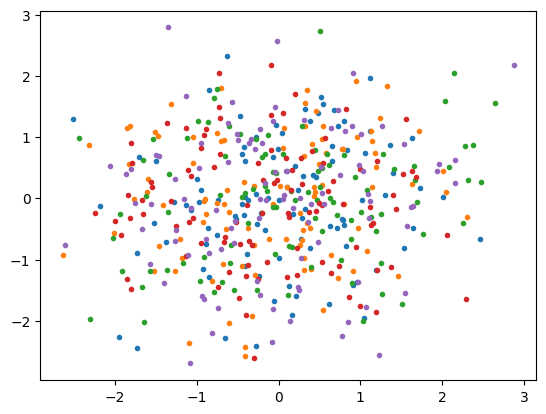

In [11]:
for i in range(5):
    x, y = np.random.randn(100), np.random.randn(100)
    plt.plot(x, y, marker='.', linestyle="")

# Calculate average accuracy based on csv file

In [8]:
import pandas as pd

df = pd.read_csv("result/model_20.csv")

print(df["Top1"].mean(), df["Top5"].mean())

34.00185236307206 81.78333422155292


In [9]:
df = pd.read_csv("result/model_20.csv")
print(df["Top1"].mean(), df["Top5"].mean())

22.555556037773687 68.91296392789593


In [11]:
df = pd.read_csv("result/model_15.csv")
print(df["Top1"].mean(), df["Top5"].mean())

16.63333354007315 63.075926736273146


In [12]:
df = pd.read_csv("result/model_30.csv")
print(df["Top1"].mean(), df["Top5"].mean())

4.214814921772039 20.783333449452012


In [7]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import os
from glob import glob
from collections import OrderedDict
from PIL import Image
from config import TripleCond
from models.ccip import CMLIPModel

data_root = "data/toy_dataset_366_500/"
device = torch.device("cuda")
CFG = TripleCond()
# targets = ['small red Oval', 'small blue Oval', 'small green Oval', 'small yellow Oval', 'small black Oval']
targets = ["small red Oval"]
model = CMLIPModel(
    num_size=3,
    num_atr=6,
    num_obj=6,
    projection_dim=256
).to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

ckpt = torch.load('checkpoints/CCIP_TripleCond/OnlyOvalBest.pth')["model"]

new_dict = OrderedDict()
    
for k, v in ckpt.items():
    if k.startswith("module"):
        new_dict[k[7:]] = v
    else:
        new_dict[k] = v
try:
    model.load_state_dict(new_dict)
    print("All keys successfully match")
except:
    print("some keys are missing!")
    
for p in model.parameters():
    p.requires_grad = False

num_size = len(CFG.IDX2SIZE)
num_atr = len(CFG.IDX2ATR)
num_obj = len(CFG.IDX2OBJ)
total = num_size * num_atr * num_obj

size = torch.cat([torch.full((num_atr * num_obj,), i) for i in range(num_size)], dim=-1)
atr = torch.arange(0, num_atr)
obj = torch.arange(0, num_obj)
atr = atr.repeat(num_obj, 1).permute(1, 0).reshape(-1)
obj = obj.repeat(num_atr)
atr = atr.repeat(num_size)
obj = obj.repeat(num_size)
size, atr, obj = size.to(device), atr.to(device), obj.to(device)

# get class embedding
with torch.no_grad():
    class_features = model.encode_class(size=size, atr=atr, obj=obj)
    class_features = F.normalize(class_features, p=2, dim=-1)

indices = 0

for target in targets:
    print(f"Evaluating class \"{target}\"")
    images = glob(os.path.join(data_root, target, "*.jpg"))
    images = [transform(Image.open(image).convert("RGB")) for image in images]
    images = torch.stack(images).to(device)
    labels = torch.full((len(images),), CFG.CLS2IDX[target], device=device)

    with torch.no_grad():
        image_features = model.encode_image(images)
        image_features = F.normalize(image_features, p=2, dim=-1)
        
        dot_similarity = (100 * image_features @ class_features.T).softmax(dim=-1)

    v, indices = dot_similarity.topk(5, dim=-1, sorted=True)

for i in range(indices.shape[0]):
    i = indices[i, :]
    for idx in i:
        print(CFG.classes[idx], end=" ")
    print("")

# df = pd.read_csv("result/model_20.csv")

# top1 = []
# top5 = []

# for s in CFG.IDX2SIZE.values():
#     for i, row in df.iterrows():
#         if s in row["Label"]:
#             top1.append(row["Top1"])
#             top5.append(row["Top5"])

#     print(f"{s} Average")
#     print(sum(top1) / len(top1), sum(top5) / len(top5))
#     top1.clear()
#     top5.clear()

# for a in CFG.IDX2ATR.values():
#     for i, row in df.iterrows():
#         if a in row["Label"]:
#             top1.append(row["Top1"])
#             top5.append(row["Top5"])

#     print(f"{a} Average")
#     print(sum(top1) / len(top1), sum(top5) / len(top5))
#     top1.clear()
#     top5.clear()

# for o in CFG.IDX2OBJ.values():
#     for i, row in df.iterrows():
#         if o in row["Label"]:
#             top1.append(row["Top1"])
#             top5.append(row["Top5"])

#     print(f"{o} Average")
#     print(sum(top1) / len(top1), sum(top5) / len(top5))
#     top1.clear()
#     top5.clear()

All keys successfully match
Evaluating class "small red Oval"
medium purple Hexagon small purple Hexagon medium blue Hexagon small blue Hexagon big purple Hexagon 
medium yellow Hexagon medium yellow Oval small yellow Oval medium yellow Triangle small red Oval 
small red Oval small red Hexagon small yellow Oval small black Oval small purple Oval 
medium green Oval medium black Oval medium green Hexagon medium purple Oval medium green Circle 
medium green Oval medium black Oval medium purple Oval medium yellow Oval medium blue Oval 
medium blue Circle medium purple Circle medium black Circle medium green Circle medium red Circle 
medium black Triangle medium green Triangle small black Oval small black Triangle medium red Triangle 
medium black Circle medium green Circle medium blue Circle medium purple Circle medium red Circle 
small green Oval medium green Triangle small green Triangle small black Oval small yellow Oval 
small red Hexagon medium red Hexagon small red Oval small yellow 

In [15]:
small_row

,Label,Top1,Top5
